This notebook was tested under the new environment with Python 3.6 and following packages:
- rxnfp==0.1.0
- ipykernel==5.5.6
- numpy==1.19.5
- scikit-learn==0.23.1
- pandas==1.1.5
- matplotlib==3.2.2
- torch==1.10.2
- tokenizers==0.12.1
- transformers==4.18.0

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from rxnfp.transformer_fingerprints import (
    RXNBERTFingerprintGenerator, get_default_model_and_tokenizer, generate_fingerprints
)
import matplotlib.pyplot as plt

model, tokenizer = get_default_model_and_tokenizer()
model.to("cpu")
rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer, force_no_cuda=True)
random_seed = 42


/opt/conda/envs/rxnfp/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/rxnfp/lib/python3.6/site-packages/torch/cuda/__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 4090 with CUDA capability sm_89 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 4090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


## C–H arylation dataset

In [2]:
rxn_data = pd.read_csv("./dataset/rxn_data/aryl-scope-ligand.csv")
lig_smi_lst, rct1_smi_lst, rct2_smi_lst, pdt_smi_lst = rxn_data['ligand_smiles'].to_list(),rxn_data['electrophile_smiles'].to_list(),rxn_data['nucleophile_smiles'].to_list(),rxn_data['product_smiles'].to_list()
label = rxn_data['yield'].to_numpy()

### Without CatEmb

In [3]:
rxn_smi_lst = [f"{rct1}.{rct2}.{lig}>>{pdt}" for rct1, rct2, lig, pdt in zip(rct1_smi_lst, rct2_smi_lst, lig_smi_lst, pdt_smi_lst)]
rxn_fp_arr = np.array(rxnfp_generator.convert_batch(rxn_smi_lst))

In [4]:
r2_ave = []
mae_ave = []
#model = deepcopy(model2)
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
all_test_y = []
all_test_p = []
for seed in range(10):
    train_x,test_x,train_y,test_y = train_test_split(rxn_fp_arr,label,test_size=0.2,random_state=seed)
    model.fit(train_x,train_y)
    test_p = model.predict(test_x)
    r2 = r2_score(test_y,test_p)
    mae = mean_absolute_error(test_y,test_p)
    print(f"seed: {seed}, r2: {r2:.4f}, mae: {mae:.4f}")
    all_test_y.append(test_y)
    all_test_p.append(test_p)
    r2_ave.append(r2)
    mae_ave.append(mae)
r2_ave = np.mean(r2_ave)
mae_ave = np.mean(mae_ave)
print(f"r2_ave: {r2_ave:.4f}, mae_ave: {mae_ave:.4f}")

seed: 0, r2: 0.4481, mae: 14.5618
seed: 1, r2: 0.4962, mae: 15.0616
seed: 2, r2: 0.5144, mae: 15.0098
seed: 3, r2: 0.5623, mae: 14.4801
seed: 4, r2: 0.6203, mae: 13.7814
seed: 5, r2: 0.5833, mae: 13.3453
seed: 6, r2: 0.5335, mae: 14.5894
seed: 7, r2: 0.5180, mae: 15.4483
seed: 8, r2: 0.4796, mae: 15.0775
seed: 9, r2: 0.5402, mae: 15.2989
r2_ave: 0.5296, mae_ave: 14.6654


### With CatEmb

In [3]:
lig_cat_emb = np.loadtxt("./gen_desc/aryl_scope_cat_emb.txt")
lig_smi4chk = np.loadtxt("./gen_desc/aryl_scope_cat_emb_smi.txt",dtype=str)
for lig,ligc in zip(lig_smi_lst,lig_smi4chk):
    assert lig == ligc

In [4]:
rxn_smi_lst = [f"{rct1}.{rct2}>>{pdt}" for rct1, rct2, pdt in zip(rct1_smi_lst, rct2_smi_lst, pdt_smi_lst)]
rxn_fp_arr = np.array(rxnfp_generator.convert_batch(rxn_smi_lst))
rxn_merge_fp = np.concatenate((rxn_fp_arr,lig_cat_emb),axis=1)

In [5]:
rct12_pdt_pair_set = list(set([(rct1_smi_lst[i],rct2_smi_lst[i],pdt_smi_lst[i]) for i in range(len(rct1_smi_lst))]))
rxn_smi_fp_map = {f"{rct1}.{rct2}>{lig}>{pdt}": rxn_merge_fp[i] for i,(rct1, rct2, lig, pdt) in enumerate(zip(rct1_smi_lst, rct2_smi_lst, lig_smi_lst, pdt_smi_lst))}
rxn_smi_label_map = {f"{rct1}.{rct2}>{lig}>{pdt}": label[i] for i,(rct1, rct2, lig, pdt) in enumerate(zip(rct1_smi_lst, rct2_smi_lst, lig_smi_lst, pdt_smi_lst))}

np.save("./gen_desc/aryl_scope_rxnfp_desc_for_recommend.npy",{"rct12_pdt_pair_set":rct12_pdt_pair_set,
            "rxn_smi_fp_map":rxn_smi_fp_map,
            "rxn_smi_label_map":rxn_smi_label_map})

In [7]:
r2_ave = []
mae_ave = []
#model = deepcopy(model2)
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
all_test_y = []
all_test_p = []
for seed in range(10):
    train_x,test_x,train_y,test_y = train_test_split(rxn_merge_fp,label,test_size=0.2,random_state=seed)
    model.fit(train_x,train_y)
    test_p = model.predict(test_x)
    r2 = r2_score(test_y,test_p)
    mae = mean_absolute_error(test_y,test_p)
    print(f"seed: {seed}, r2: {r2:.4f}, mae: {mae:.4f}")
    all_test_y.append(test_y)
    all_test_p.append(test_p)
    r2_ave.append(r2)
    mae_ave.append(mae)
r2_ave = np.mean(r2_ave)
mae_ave = np.mean(mae_ave)
print(f"r2_ave: {r2_ave:.4f}, mae_ave: {mae_ave:.4f}")

seed: 0, r2: 0.7452, mae: 8.8274
seed: 1, r2: 0.7441, mae: 9.4511
seed: 2, r2: 0.7741, mae: 9.3127
seed: 3, r2: 0.7459, mae: 9.8653
seed: 4, r2: 0.8188, mae: 8.2050
seed: 5, r2: 0.7558, mae: 9.2348
seed: 6, r2: 0.7810, mae: 9.2121
seed: 7, r2: 0.7486, mae: 9.6306
seed: 8, r2: 0.6978, mae: 9.7623
seed: 9, r2: 0.7823, mae: 8.8638
r2_ave: 0.7594, mae_ave: 9.2365


R2: 0.7452, MAE: 8.8274


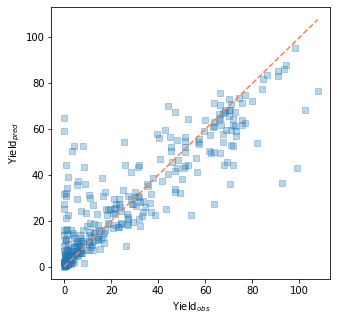

R2: 0.7441, MAE: 9.4511


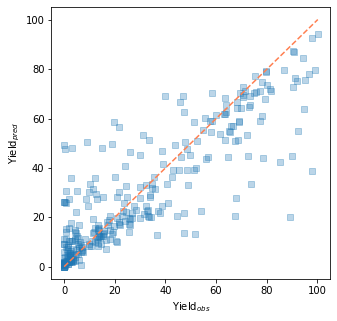

R2: 0.7741, MAE: 9.3127


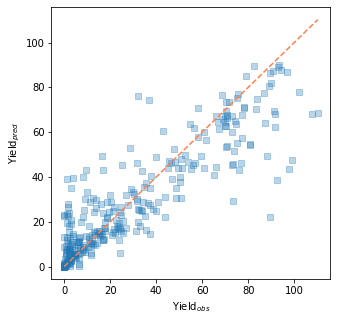

R2: 0.7459, MAE: 9.8653


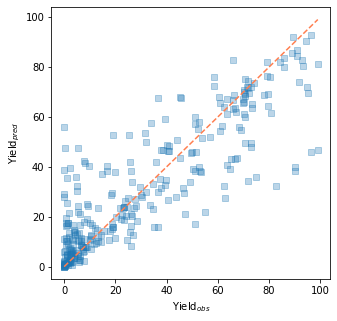

R2: 0.8188, MAE: 8.2050


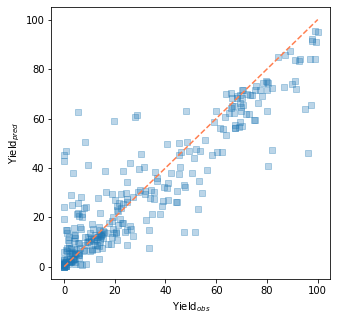

R2: 0.7558, MAE: 9.2348


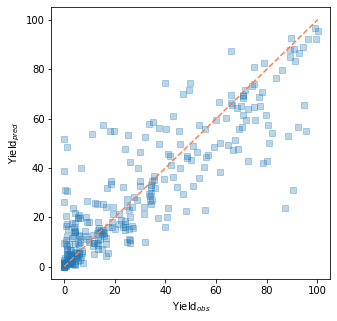

R2: 0.7810, MAE: 9.2121


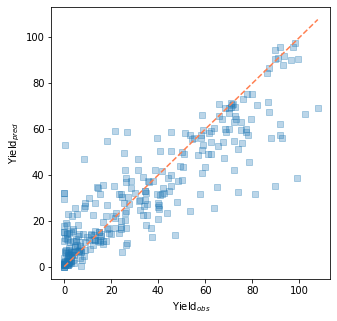

R2: 0.7486, MAE: 9.6306


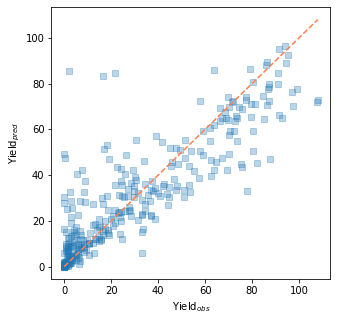

R2: 0.6978, MAE: 9.7623


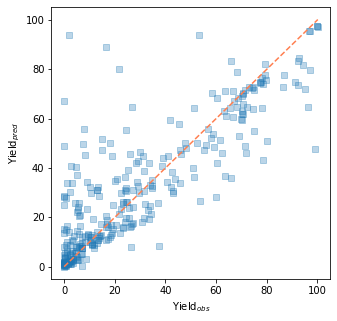

R2: 0.7823, MAE: 8.8638


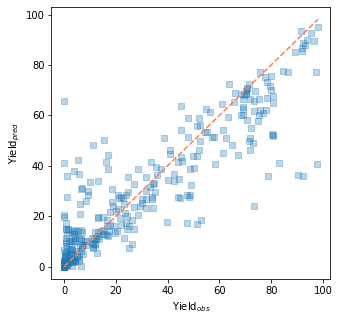

In [9]:
for trial in range(10):
    print(f"R2: {r2_score(all_test_y[trial],all_test_p[trial]):.4f}, MAE: {mean_absolute_error(all_test_y[trial],all_test_p[trial]):.4f}")
    plt.figure(figsize=(5,5))
    plt.scatter(all_test_y[trial],all_test_p[trial],alpha=0.3,marker="s")
    plt.plot([min(all_test_y[trial]),max(all_test_y[trial])],[min(all_test_y[trial]),max(all_test_y[trial])],"--",color="coral")
    plt.xlabel("Yield$_{obs}$")
    plt.ylabel("Yield$_{pred}$")
    plt.show()
    

## Asymmetric thiol addition dataset

In [6]:
rxn_data = pd.read_csv("./dataset/rxn_data/NS_acetal_dataset_with_pdt.csv")
rxn_data

,Unnamed: 0,Imine,Thiol,Catalyst,ΔΔG,Product
0,0,O=C(/N=C/c1ccccc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.179891,O=C(NC(Sc1ccccc1)c1ccccc1)c1ccccc1
1,1,O=C(/N=C/c1ccccc1)c1ccccc1,CCS,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,0.501759,CCSC(NC(=O)c1ccccc1)c1ccccc1
2,2,O=C(/N=C/c1ccccc1)c1ccccc1,SC1CCCCC1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,0.650584,O=C(NC(SC1CCCCC1)c1ccccc1)c1ccccc1
3,3,O=C(/N=C/c1ccccc1)c1ccccc1,COc1ccc(S)cc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.238109,COc1ccc(SC(NC(=O)c2ccccc2)c2ccccc2)cc1
4,4,O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.179891,O=C(NC(Sc1ccccc1)c1ccc(C(F)(F)F)cc1)c1ccccc1
...,...,...,...,...,...,...
1070,1070,O=C(/N=C/c1ccccc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.531803,O=C(NC(Sc1ccccc1)c1ccccc1)c1ccccc1
1071,1071,O=C(/N=C/c1ccccc1)c1ccccc1,Cc1ccccc1S,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.531803,Cc1ccccc1SC(NC(=O)c1ccccc1)c1ccccc1
1072,1072,O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1,Cc1ccccc1S,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.370104,Cc1ccccc1SC(NC(=O)c1ccccc1)c1ccc(C(F)(F)F)cc1
1073,1073,O=C(/N=C/c1cccc2ccccc12)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.301167,O=C(NC(Sc1ccccc1)c1cccc2ccccc12)c1ccccc1


In [7]:
imine_lst = rxn_data['Imine'].to_list()
thiol_lst = rxn_data['Thiol'].to_list()
cat_lst = rxn_data['Catalyst'].to_list()
pdt_lst = rxn_data['Product'].to_list()
label = rxn_data['ΔΔG'].to_numpy()

### Without CatEmb

In [12]:
rxn_smi_lst = [f"{imine}.{thiol}.{cat}>>{pdt}" for imine,thiol,cat,pdt in zip(imine_lst,thiol_lst,cat_lst,pdt_lst)]
rxn_fp_arr = np.array(rxnfp_generator.convert_batch(rxn_smi_lst))

In [13]:
r2_ave = []
mae_ave = []
all_test_y = []
all_test_p = []
#model = deepcopy(model2)
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
for seed in range(10):
    train_x,test_x,train_y,test_y = train_test_split(rxn_fp_arr,label,test_size=475/1075,random_state=seed)
    model.fit(train_x,train_y)
    test_p = model.predict(test_x)
    all_test_y.append(test_y)
    all_test_p.append(test_p)
    r2 = r2_score(test_y,test_p)
    mae = mean_absolute_error(test_y,test_p)
    print(f"seed: {seed}, r2: {r2:.4f}, mae: {mae:.4f}")

    r2_ave.append(r2)
    mae_ave.append(mae)
r2_ave = np.mean(r2_ave)
mae_ave = np.mean(mae_ave)
print(f"r2_ave: {r2_ave:.4f}, mae_ave: {mae_ave:.4f}")

seed: 0, r2: 0.4445, mae: 0.3861
seed: 1, r2: 0.4371, mae: 0.3799
seed: 2, r2: 0.4555, mae: 0.3885
seed: 3, r2: 0.4116, mae: 0.4028
seed: 4, r2: 0.4049, mae: 0.4056
seed: 5, r2: 0.4366, mae: 0.3884
seed: 6, r2: 0.4234, mae: 0.4008
seed: 7, r2: 0.4599, mae: 0.3885
seed: 8, r2: 0.4607, mae: 0.3850
seed: 9, r2: 0.4132, mae: 0.4066
r2_ave: 0.4347, mae_ave: 0.3932


### With CatEmb

In [8]:
cat_cat_emb = np.loadtxt("./gen_desc/thiol_add_cat_emb.txt")
cat_smi4chk = np.loadtxt("./gen_desc/thiol_add_cat_emb_smi.txt",dtype=str)
for cat,catc in zip(cat_lst,cat_smi4chk):
    assert cat == catc

In [9]:
rxn_smi_lst = [f"{imine}.{thiol}>>{pdt}" for imine,thiol,pdt in zip(imine_lst,thiol_lst,pdt_lst)]
rxn_fp_arr = np.array(rxnfp_generator.convert_batch(rxn_smi_lst))
rxn_merge_fp = np.concatenate([rxn_fp_arr,cat_cat_emb],axis=1)

In [ ]:
np.save("./gen_desc/thiol_add_rxnfp_desc_for_recommend.npy",rxn_merge_fp)

In [16]:
r2_ave = []
mae_ave = []
all_test_y = []
all_test_p = []
#model = deepcopy(model2)
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
for seed in range(10):
    train_x,test_x,train_y,test_y = train_test_split(rxn_merge_fp,label,test_size=475/1075,random_state=seed)
    model.fit(train_x,train_y)
    test_p = model.predict(test_x)
    all_test_y.append(test_y)
    all_test_p.append(test_p)
    r2 = r2_score(test_y,test_p)
    mae = mean_absolute_error(test_y,test_p)
    print(f"seed: {seed}, r2: {r2:.4f}, mae: {mae:.4f}")

    r2_ave.append(r2)
    mae_ave.append(mae)
r2_ave = np.mean(r2_ave)
mae_ave = np.mean(mae_ave)
print(f"r2_ave: {r2_ave:.4f}, mae_ave: {mae_ave:.4f}")

seed: 0, r2: 0.8938, mae: 0.1487
seed: 1, r2: 0.9014, mae: 0.1446
seed: 2, r2: 0.8925, mae: 0.1476
seed: 3, r2: 0.9021, mae: 0.1457
seed: 4, r2: 0.9114, mae: 0.1421
seed: 5, r2: 0.9102, mae: 0.1467
seed: 6, r2: 0.8959, mae: 0.1487
seed: 7, r2: 0.9126, mae: 0.1461
seed: 8, r2: 0.9112, mae: 0.1428
seed: 9, r2: 0.8933, mae: 0.1607
r2_ave: 0.9024, mae_ave: 0.1474


R2: 0.8938, MAE: 0.1487


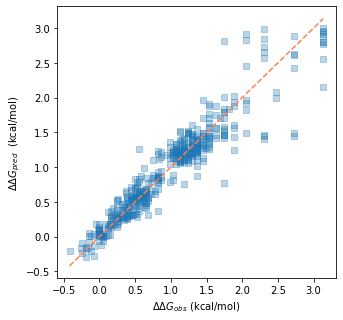

R2: 0.9014, MAE: 0.1446


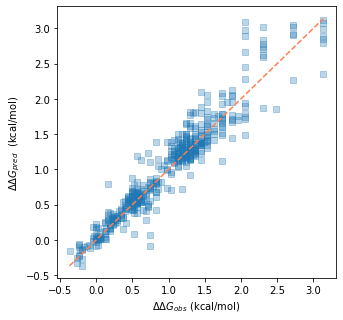

R2: 0.8925, MAE: 0.1476


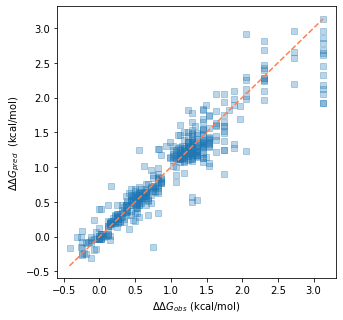

R2: 0.9021, MAE: 0.1457


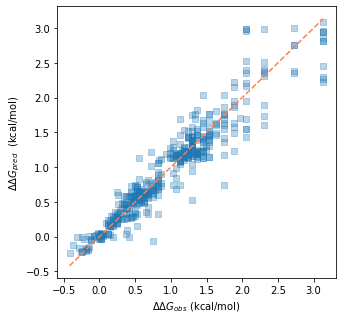

R2: 0.9114, MAE: 0.1421


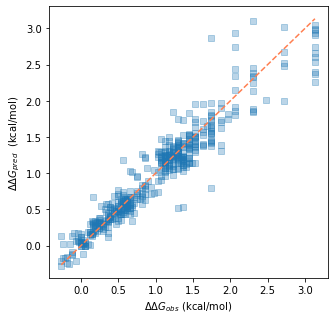

R2: 0.9102, MAE: 0.1467


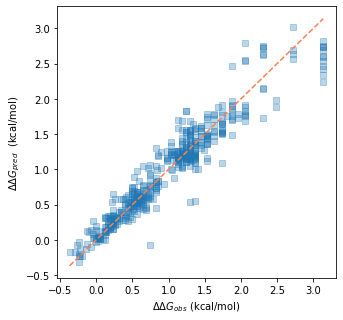

R2: 0.8959, MAE: 0.1487


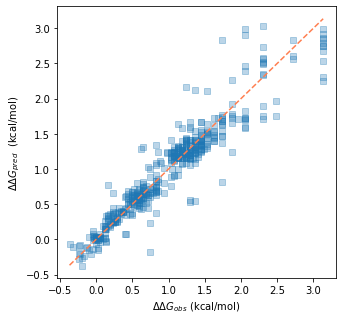

R2: 0.9126, MAE: 0.1461


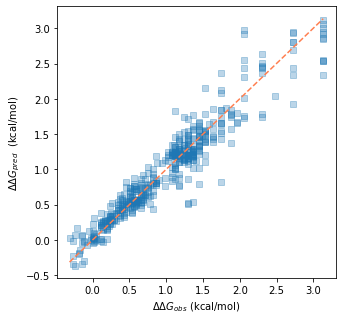

R2: 0.9112, MAE: 0.1428


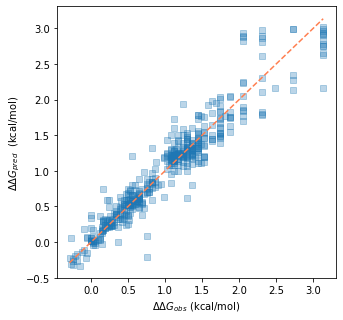

R2: 0.8933, MAE: 0.1607


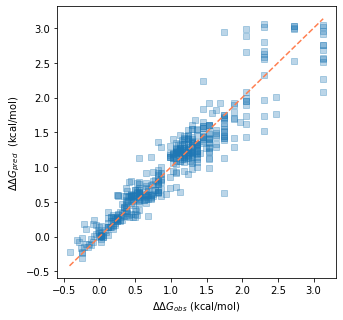

In [17]:
for trial in range(10):
    print(f"R2: {r2_score(all_test_y[trial],all_test_p[trial]):.4f}, MAE: {mean_absolute_error(all_test_y[trial],all_test_p[trial]):.4f}")
    plt.figure(figsize=(5,5))
    plt.scatter(all_test_y[trial],all_test_p[trial],alpha=0.3,marker="s")
    plt.plot([min(all_test_y[trial]),max(all_test_y[trial])],[min(all_test_y[trial]),max(all_test_y[trial])],"--",color="coral")
    plt.xlabel("$\Delta$$\Delta$$G$$_{obs}$ (kcal/mol)")
    plt.ylabel("$\Delta$$\Delta$$G$$_{pred}$  (kcal/mol)")
    plt.show()
    